In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

#### Data

In [215]:
resolution = '5m'
perps = ['ZEC-PERP', 'XMR-PERP']

ohlc = {}
prices = {}
for perp in perps:
    data = []
    try:
        data = pd.read_parquet('C:/Users/Walid/Desktop/Workspace/data/{}_{}.parquet.gzip'.format(perp, resolution))
    except:
        print('Cannot find {} data'.format(perp))
    
    if len(data) > 0:
        data['startTime'] = data['startTime'].apply(lambda x: datetime.fromisoformat(x))
        ohlc[perp] = data.set_index('startTime')
        prices[perp] = ohlc[perp]['close']

prices = pd.DataFrame(prices).dropna()

#### Mean reversion (static)

##### Trading Signals

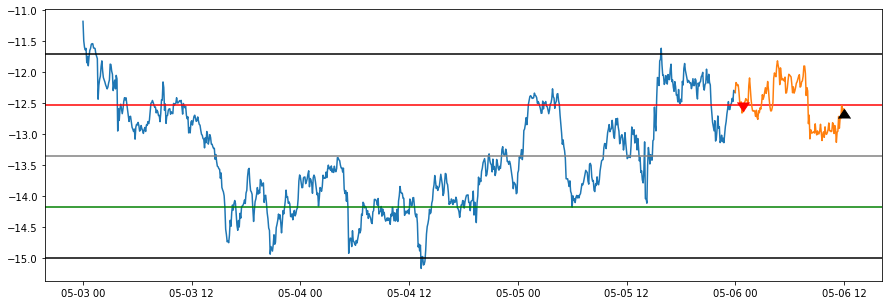

In [385]:
formation_start_time = datetime.fromisoformat('2022-05-03 00:00:00+00:00')
formation_end_time = datetime.fromisoformat('2022-05-06 00:00:00+00:00')
trading_start_time = datetime.fromisoformat('2022-05-06 00:00:00+00:00')
trading_end_time = datetime.fromisoformat('2022-05-06 12:00:00+00:00')


# Make mean reverting portfolio
formation_prices = prices[formation_start_time:formation_end_time]
jres = coint_johansen(formation_prices, 0, 1)
cointegrated = jres.max_eig_stat[0] > jres.max_eig_stat_crit_vals[0][1]
evec = jres.evec[0]
formation_portfolio = (evec * formation_prices).sum(axis=1)
formation_mean = formation_portfolio.mean()
formation_std = formation_portfolio.std()

trading_prices = prices[trading_start_time:trading_end_time]
trading_portfolio = (evec * trading_prices).sum(axis=1)


# Trading positions
positions = [0, 0]
std_multiple = 1
long_signal = formation_mean - formation_std * std_multiple
short_signal = formation_mean + formation_std * std_multiple
exit_signal = formation_mean
long_stop_signal = formation_mean - formation_std * std_multiple * 2
short_stop_signal = formation_mean + formation_std * std_multiple * 2
for i in range(2, len(trading_portfolio.index)):
    if trading_portfolio.iloc[i-2] < long_signal and trading_portfolio.iloc[i-1] > long_signal:
        # open long
        positions.append(1)
    elif trading_portfolio.iloc[i-2] > short_signal and trading_portfolio.iloc[i-1] < short_signal:
        # open short
        positions.append(-1)
    elif positions[i-2] == 1 and trading_portfolio.iloc[i-1] > exit_signal:
        # close long
        positions.append(0)
    elif positions[i-1] == -1 and trading_portfolio.iloc[i-1] < exit_signal:
        # close short
        positions.append(0)
    elif positions[i-1] == 1 and trading_portfolio.iloc[i-1] < long_stop_signal:
        # Take loss
        positions.append(0)
    elif positions[i-1] == -1 and trading_portfolio.iloc[i-1] > short_stop_signal:
        # Take loss
        positions.append(0)
    else:
        positions.append(positions[i-1])


taker_fee = 0.0007
trades = []
for i in range(1, len(positions)):
    # Position opened
    if positions[i-1] == 0 and positions[i] != 0:
        open_spread = trading_portfolio.iloc[i]
        open_trade_index = i

    # Position closed (force close if at last trading bar)
    if positions[i-1] != 0 and (positions[i] == 0 or i == len(positions) - 1):
        open_spread = trading_portfolio.iloc[open_trade_index]
        close_spread = trading_portfolio.iloc[i]
        pnl = ((close_spread - close_spread * taker_fee) - (open_spread - open_spread * taker_fee)) * positions[i-1]

        trades.append({
            'position': 'long' if positions[i-1] > 0 else 'short',
            'open_date': trading_portfolio.index[open_trade_index],
            'open_spread': open_spread,
            'close_date': trading_portfolio.index[i],
            'close_spread': close_spread,
            'pnl': pnl,
            'duration': trading_portfolio.index[i] - trading_portfolio.index[open_trade_index]
        })

        open_trade_index = None


trades = pd.DataFrame(trades)


# Visualize
plt.figure(figsize=(15,5))
plt.plot(formation_portfolio)
plt.axhline(short_signal, color='r')
plt.axhline(long_signal, color='g')
plt.axhline(formation_mean, color='grey')
plt.axhline(short_stop_signal, color='black')
plt.axhline(long_stop_signal, color='black')

plt.plot(trading_portfolio)

if len(trades) > 0:
    longs_open_markers = trades.loc[trades['position'] == 'long', 'open_date':'open_spread'].set_index('open_date')
    longs_close_markers = trades.loc[trades['position'] == 'long', 'close_date':'close_spread'].set_index('close_date')
    shorts_open_markers = trades.loc[trades['position'] == 'short', 'open_date':'open_spread'].set_index('open_date')
    shorts_close_markers = trades.loc[trades['position'] == 'short', 'close_date':'close_spread'].set_index('close_date')

    plt.plot(longs_open_markers, linestyle='None', marker=6, color='g', markersize=12)
    plt.plot(longs_close_markers, linestyle='None', marker=7, color='black', markersize=12)
    plt.plot(shorts_open_markers, linestyle='None', marker=7, color='r', markersize=12)
    plt.plot(shorts_close_markers, linestyle='None', marker=6, color='black', markersize=12)
    



##### PNL Calculation

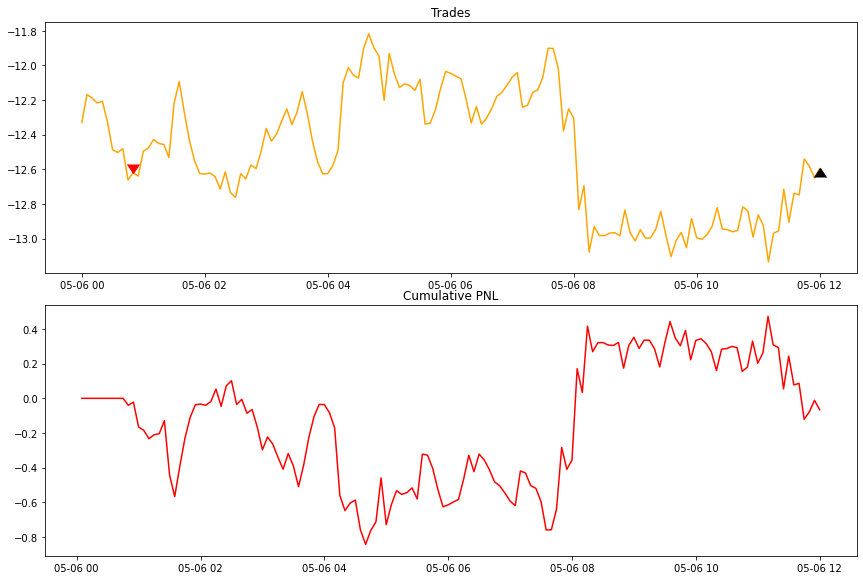

In [386]:
trades_pnl = trading_portfolio.diff() * positions
cumulative_pnl = trades_pnl.cumsum()

fig, axes = plt.subplots(2,1, figsize=(12,8))
fig.tight_layout()
axes[0].plot(trading_portfolio, color='orange')
axes[0].title.set_text("Trades")
axes[0].plot(longs_open_markers, linestyle='None', marker=6, color='g', markersize=12)
axes[0].plot(longs_close_markers, linestyle='None', marker=7, color='black', markersize=12)
axes[0].plot(shorts_open_markers, linestyle='None', marker=7, color='r', markersize=12)
axes[0].plot(shorts_close_markers, linestyle='None', marker=6, color='black', markersize=12)

axes[1].plot(cumulative_pnl, color='g' if cumulative_pnl.iloc[-1] > 0 else 'r')
axes[1].title.set_text("Cumulative PNL")



#### Trades Statistics

In [371]:
trades


""


In [363]:
evec

array([0.04329301, 0.37632092])

In [219]:
formation_prices

,ZEC-PERP,XMR-PERP
startTime,,
2022-01-03 00:00:00+00:00,152.76,239.09
2022-01-03 00:05:00+00:00,152.21,237.34
2022-01-03 00:10:00+00:00,152.19,236.34
2022-01-03 00:15:00+00:00,152.32,235.87
2022-01-03 00:20:00+00:00,152.68,237.29
...,...,...
2022-02-16 23:40:00+00:00,126.63,180.27
2022-02-16 23:45:00+00:00,126.26,180.20
2022-02-16 23:50:00+00:00,125.75,179.41


In [220]:
(evec * formation_prices)

,ZEC-PERP,XMR-PERP
startTime,,
2022-01-03 00:00:00+00:00,16.980619,-15.132846
2022-01-03 00:05:00+00:00,16.919482,-15.022082
2022-01-03 00:10:00+00:00,16.917259,-14.958789
2022-01-03 00:15:00+00:00,16.931709,-14.929041
2022-01-03 00:20:00+00:00,16.971726,-15.018918
...,...,...
2022-02-16 23:40:00+00:00,14.076040,-11.409922
2022-02-16 23:45:00+00:00,14.034911,-11.405491
2022-02-16 23:50:00+00:00,13.978220,-11.355489


In [221]:
cointegrated

False